In [1]:
import numpy as np # linear algebra
import pandas as pd 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time
from sklearn.model_selection import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline
import re

pd.set_option('display.max_rows',None)

In [2]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample_sub = pd.read_excel('Sample_Submission.xlsx')

In [4]:
# I have renamed columns in excel before importing the dataset for better understanding
train.head()

,product,brand,category,subcategory,variant,rating,date,price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,02-03-2017,291
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,07-01-2015,897
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,01-12-2019,792
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12-12-2014,837
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12-12-2013,470


In [5]:
print(train.shape)

(2452, 8)


In [6]:
print(test.shape)

(1051, 7)


In [7]:
# processing date column
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
train['day'] = train['date'].dt.dayofweek
test['day'] = test['date'].dt.dayofweek
train['year_rating'] = train['year'] + train['rating']
test['year_rating'] = test['year'] + test['rating']
train['month_rating'] = train['month'] + train['rating']
test['month_rating'] = test['month'] + test['rating']

In [8]:
train.head()

,product,brand,category,subcategory,variant,rating,date,price,year,month,day,year_rating,month_rating
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-02-03,291,2017,2,4,2021.3,6.3
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,897,2015,7,2,2018.1,10.1
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-01-12,792,2019,1,5,2022.5,4.5
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,837,2014,12,4,2018.0,16.0
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,470,2013,12,3,2017.3,16.3


In [9]:
test.head()

,product,brand,category,subcategory,variant,rating,date,year,month,day,year_rating,month_rating
0,P-11284,B-2984,computers,network components,routers,4.3,2018-01-12,2018,1,4,2022.3,5.3
1,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,2012-12-20,2012,12,3,2015.0,15.0
2,P-5843,B-3078,clothing,women s clothing,western wear,1.5,2014-01-12,2014,1,6,2015.5,2.5
3,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,2019-01-12,2019,1,5,2022.9,4.9
4,P-5586,B-3078,clothing,women s clothing,western wear,1.4,2017-01-12,2017,1,3,2018.4,2.4


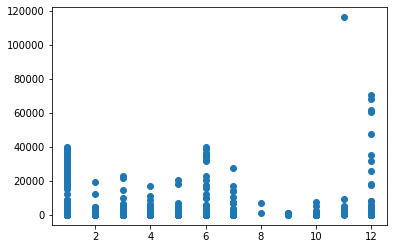

In [10]:
plt.scatter(train['month'],train['price'])

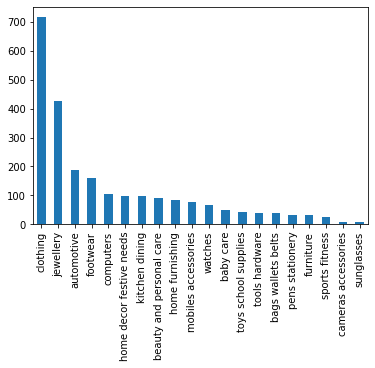

In [11]:
train['category'].value_counts()[:20].plot(kind='bar')

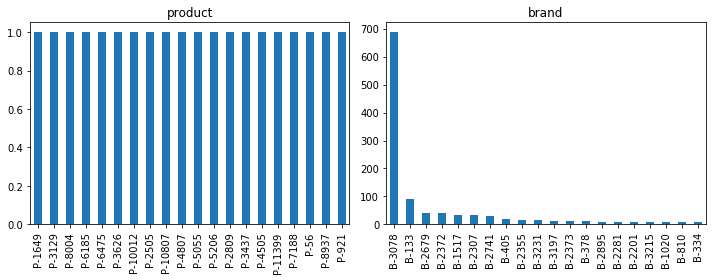

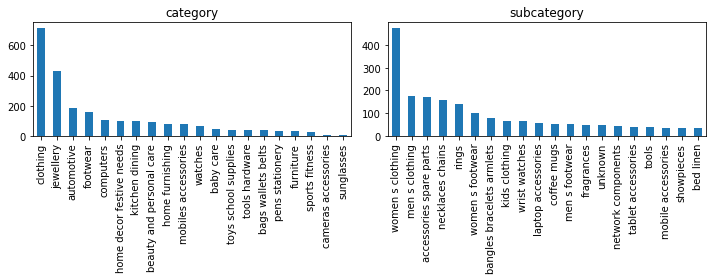

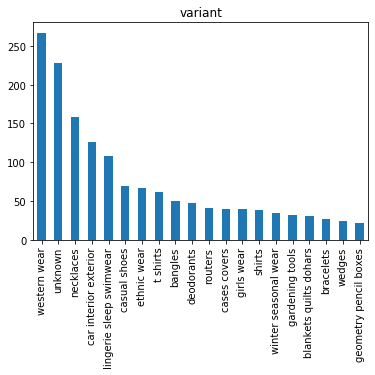

In [12]:
# Function to perform univariate analysis of categorical columns
def plot_categorical_columns(dataframe):
    categorical_columns = dataframe.select_dtypes(include=['object']).columns
    
    for i in range(0,len(categorical_columns),2):
            if len(categorical_columns) > i+1:
                
                plt.figure(figsize=(10,4))
                plt.subplot(121)
                dataframe[categorical_columns[i]].value_counts()[:20].plot(kind='bar')
                plt.title(categorical_columns[i])
                plt.subplot(122)     
                dataframe[categorical_columns[i+1]].value_counts()[:20].plot(kind='bar')
                plt.title(categorical_columns[i+1])
                plt.tight_layout()
                plt.show()

            else:
                dataframe[categorical_columns[i]].value_counts()[:20].plot(kind='bar')
                plt.title(categorical_columns[i])
        
                
plot = plot_categorical_columns(train)

## Modelling & Feature Engineering

####  I found a wonderful blog/kaggle kernel on handling high cardinality categorical variables.below code was used from that kaggle kernel.
#### mean encoding on cateorical variables gave me a very good boost in my cv score. I had also tried frequency & median encoding.

#### Link to the kernel :- https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study

In [15]:
def mean_encode(train_data, test_data, columns, target_col, reg_method=None,
                alpha=5, add_random=False, rmean=0, rstd=0.1, folds=1):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + 
                                 target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        if reg_method == 'expanding_mean':
            train_data_shuffled = train_data.sample(frac=1, random_state=1)
            cumsum = train_data_shuffled.groupby(col)[target_col].cumsum() - train_data_shuffled[target_col]
            cumcnt = train_data_shuffled.groupby(col).cumcount()
            encoded_col_train = cumsum/(cumcnt)
            encoded_col_train.fillna(target_mean_global, inplace=True)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))
        elif (reg_method == 'k_fold') and (folds > 1):
            kfold = KFold( n_splits = 10, shuffle = False)
            parts = []
            for tr_in, val_ind in kfold.split(train_data):
                # divide data
                df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
                # getting means on data for estimation (all folds except estimated)
                nrows_cat = df_for_estimation.groupby(col)[target_col].count()
                target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
                target_means_cats_adj = (target_means_cats*nrows_cat + 
                                         target_mean_global*alpha)/(nrows_cat+alpha)
                # Mapping means to estimated fold
                encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
                if add_random:
                    encoded_col_train_part = encoded_col_train_part + normal(loc=rmean, scale=rstd, 
                                                                             size=(encoded_col_train_part.shape[0]))
                # Saving estimated encodings for a fold
                parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis=0)
            encoded_col_train.fillna(target_mean_global, inplace=True)
        else:
            encoded_col_train = train_data[col].map(target_means_cats_adj)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+target_col+'_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return all_encoded

In [16]:
cols = ['brand','category','subcategory','variant','rating','month_rating']
target = 'price'
finaldf = mean_encode(train,test,cols,target,reg_method='k_fold',folds=5)

In [17]:
finaldf.shape

(3503, 6)

In [18]:
train_encoded = finaldf.iloc[0:2452,:]

In [19]:
train_encoded.shape

(2452, 6)

In [20]:
test_encoded = finaldf.iloc[2452:,:]

In [21]:
test_encoded.shape

(1051, 6)

In [22]:
train_encoded.head(7)

,mean_price_brand,mean_price_category,mean_price_subcategory,mean_price_variant,mean_price_rating,mean_price_month_rating
0,2494.375612,1951.253284,1608.237174,2224.117379,1873.886953,2107.271003
1,800.592457,716.976628,652.050879,690.840494,2940.965214,1309.682928
2,2135.313010,1516.033081,1863.761119,1741.757533,2313.876940,2855.342524
3,800.592457,736.335709,2244.479676,2494.375612,2390.033081,1746.475122
4,800.592457,716.976628,903.053482,692.431301,1873.886953,1526.463415
5,2494.375612,1516.033081,1575.676275,1594.919861,1616.931520,5290.888319
6,800.592457,1128.379858,1014.792557,1431.331566,2156.281301,4065.658537


In [23]:
test_encoded.head(7)

,mean_price_brand,mean_price_category,mean_price_subcategory,mean_price_variant,mean_price_rating,mean_price_month_rating
0,2304.268294,2142.035579,3442.061235,3509.801697,1716.958922,2349.375083
1,2494.375612,8172.371543,1046.949732,1778.558689,3102.076338,1449.072233
2,793.139795,713.931964,649.613052,673.940728,2317.580270,2183.726079
3,1567.430895,8172.371543,574.053806,572.453240,1053.722035,1361.610695
4,793.139795,713.931964,649.613052,673.940728,2349.265680,3956.937670
5,793.139795,713.931964,649.613052,673.940728,3891.947086,3716.082230
6,1907.982580,2272.875038,3510.830430,1705.734757,4285.935595,1381.204108


In [24]:
train_encoded = pd.concat([train_encoded,train['month']],axis=1)
test_encoded = pd.concat([test_encoded,test['month']],axis=1)

In [25]:
X = train_encoded.copy()
y = train['price']
Xt = test_encoded.copy()

In [26]:
features = [c for c in X.columns]

In [27]:
features

['mean_price_brand',
 'mean_price_category',
 'mean_price_subcategory',
 'mean_price_variant',
 'mean_price_rating',
 'mean_price_month_rating',
 'month']

## Light GBM Regressor

In [28]:
training_start_time = time.time()

rmsle = list()
max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(X))
test_preds = np.zeros(len(Xt))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, pd.qcut(y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    X_trn, y_trn = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test = Xt[features]
     
    lgbm = LGBMRegressor(n_estimators=1000, num_leaves=127, max_depth=-1,min_child_samples=4, learning_rate=0.02, colsample_bytree=0.4, reg_alpha=0.5, reg_lambda=2)
    _ = lgbm.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=100, eval_metric='rmse')

    oofs[val_idx] = np.exp(lgbm.predict(X_val))
    current_test_pred = np.exp(lgbm.predict(X_test))
    test_preds += np.exp(lgbm.predict(X_test))/max_iter
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    rmsle = np.append(rmsle, rmse(np.log(y_val), np.log(oofs[val_idx])))
    
    
print(f'\nOOF val score: {rmse(np.log(y), np.log(oofs))}')
print(f'Mean rmsle: {np.mean(rmsle):.4f} and std Dev. is {np.std(rmsle):.2f} \n')


---- Fold 0 -----

7 7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.685023	valid_0's l2: 0.469257
[200]	valid_0's rmse: 0.649773	valid_0's l2: 0.422204
[300]	valid_0's rmse: 0.644499	valid_0's l2: 0.415379
[400]	valid_0's rmse: 0.64479	valid_0's l2: 0.415755
Early stopping, best iteration is:
[325]	valid_0's rmse: 0.643809	valid_0's l2: 0.41449

 Fold 0.6438086113754323

---- Fold 1 -----

7 7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.764383	valid_0's l2: 0.584282
[200]	valid_0's rmse: 0.743463	valid_0's l2: 0.552737
Early stopping, best iteration is:
[181]	valid_0's rmse: 0.742942	valid_0's l2: 0.551962

 Fold 0.7429415390903663

---- Fold 2 -----

7 7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.661734	valid_0's l2: 0.437892
[200]	valid_0's rmse: 0.617006	valid_0's l2: 0.380696
[300]	valid_0's rmse: 0.615949	valid_0's l2: 0.379394
[400]	valid_0's rmse: 0.6167

In [29]:
vp0, tp0 = oofs, test_preds

In [30]:
sub = pd.DataFrame({'Selling_Price': tp0})
sub['Selling_Price'] = np.clip(sub['Selling_Price'], y.min(), y.max())
sub['Selling_Price'].describe()

count     1051.000000
mean      1710.157467
std       4480.112459
min        199.861497
25%        534.847057
50%        706.934158
75%        998.171953
max      36552.143581
Name: Selling_Price, dtype: float64

In [31]:
sub.head(10)

,Selling_Price
0,2591.405423
1,596.874595
2,613.302248
3,371.213125
4,568.792021
5,521.485211
6,753.846968
7,20401.127038
8,26538.681774
9,334.034608


In [32]:
sub.to_excel(mean_encoding_lgbm2.xlsx, index=False)

In [33]:
feat_imp = pd.DataFrame({'columns':X.columns,'feature_importance':lgbm.feature_importances_})
feat_imp

,columns,feature_importance
0,mean_price_brand,4197
1,mean_price_category,5015
2,mean_price_subcategory,4942
3,mean_price_variant,4996
4,mean_price_rating,5422
5,mean_price_month_rating,6035
6,month,2657


## XGboost Regressor

In [34]:
training_start_time = time.time()
rsmle = list()
max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(X))
test_preds = np.zeros(len(Xt))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, pd.qcut(y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    X_trn, y_trn = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test = Xt[features]
    
    xgb = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.05, colsample_bytree=0.45)
    _ = xgb.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=100, eval_metric='rmse')
    
    oofs[val_idx] = np.exp(xgb.predict(X_val))
    current_test_pred = np.exp(xgb.predict(X_test))
    test_preds += np.exp(xgb.predict(X_test))/max_iter
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    rmsle = np.append(rmsle, rmse(np.log(y_val), np.log(oofs[val_idx])))
    

print(f'\nOOF val score: {rmse(np.log(y), np.log(oofs))}')
print(f'Mean rmsle: {np.mean(rmsle):.4f} and std Dev. is {np.std(rmsle):.2f} \n')


---- Fold 0 -----

7 7
[14:23:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.01393
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\RAKESH\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.665552
[200]	validation_0-rmse:0.664685
Stopping. Best iteration:
[122]	validation_0-rmse:0.661622


 Fold 0.6616217009941979

---- Fold 1 -----

7 7
[14:23:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.95612
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\RAKESH\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.763839
Stopping. Best iteration:
[95]	validation_0-rmse:0.762377


 Fold 0.7623764971509563

---- Fold 2 -----

7 7
[14:23:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.94446
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\RAKESH\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.62348
[200]	validation_0-rmse:0.621415
Stopping. Best iteration:
[143]	validation_0-rmse:0.618678


 Fold 0.6186781714835115

---- Fold 3 -----

7 7
[14:23:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.92234
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\RAKESH\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.594242
[200]	validation_0-rmse:0.595877
Stopping. Best iteration:
[122]	validation_0-rmse:0.589198


 Fold 0.589197899129492

---- Fold 4 -----

7 7
[14:23:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.92278
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\RAKESH\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.675816
[200]	validation_0-rmse:0.66889
Stopping. Best iteration:
[152]	validation_0-rmse:0.668405


 Fold 0.6684054641837002

---- Fold 5 -----

7 7
[14:23:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.93968
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\RAKESH\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.557224
[200]	validation_0-rmse:0.5589
Stopping. Best iteration:
[119]	validation_0-rmse:0.554674


 Fold 0.5546738332554141

---- Fold 6 -----

7 7
[14:23:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.9277
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\RAKESH\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.624895
[200]	validation_0-rmse:0.627522
Stopping. Best iteration:
[112]	validation_0-rmse:0.622161


 Fold 0.6221613982726605

---- Fold 7 -----

7 7
[14:23:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.97739
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\RAKESH\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.670545
[200]	validation_0-rmse:0.669983
Stopping. Best iteration:
[124]	validation_0-rmse:0.662777


 Fold 0.6627772613319405

---- Fold 8 -----

7 7
[14:23:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.94874
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\RAKESH\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.669769
[200]	validation_0-rmse:0.670062
Stopping. Best iteration:
[110]	validation_0-rmse:0.665936


 Fold 0.6659366371356683

---- Fold 9 -----

7 7
[14:23:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.00541
Will train until validation_0-rmse hasn't improved in 100 rounds.


C:\Users\RAKESH\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.645035
[200]	validation_0-rmse:0.643366
Stopping. Best iteration:
[154]	validation_0-rmse:0.640248


 Fold 0.6402484844558973

OOF val score: 0.6468229184357003
Mean rmsle: 0.6424 and std Dev. is 0.05 



In [35]:
vp1, tp1 = oofs, test_preds

In [36]:
sub = pd.DataFrame({'Selling_Price': tp1})
sub['Selling_Price'] = np.clip(sub['Selling_Price'], y.min(), y.max())
sub['Selling_Price'].describe()

count     1051.000000
mean      1724.226655
std       4726.580401
min        192.417725
25%        512.936945
50%        687.188286
75%        961.317192
max      47153.482910
Name: Selling_Price, dtype: float64

In [37]:
sub.head(10)

,Selling_Price
0,2474.274780
1,505.326077
2,614.548897
3,392.805653
4,584.099537
5,467.046844
6,756.160885
7,18756.812866
8,26567.247559
9,336.728607


In [38]:
sub.to_excel(mean_encoding_xgb2.xlsx, index=False)

## Catboost Regressor

In [39]:
rmsle = list()
max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(X))
test_preds = np.zeros(len(Xt))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, pd.qcut(y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    X_trn, y_trn = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test = Xt[features]
    
    cat = CatBoostRegressor(n_estimators=2000, learning_rate=0.05, max_depth=9, rsm=0.5)
    _ = cat.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=100)
    
    oofs[val_idx] = np.exp(cat.predict(X_val))
    current_test_pred = np.exp(cat.predict(X_test))
    test_preds += np.exp(cat.predict(X_test))/max_iter
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    rmsle = np.append(rmsle, rmse(np.log(y_val), np.log(oofs[val_idx])))
    

print(f'\nOOF val score: {rmse(np.log(y), np.log(oofs))}')
print(f'Mean rmsle: {np.mean(rmsle):.4f} and std Dev. is {np.std(rmsle):.2f} \n')


---- Fold 0 -----

7 7
0:	learn: 1.1378334	test: 1.2106431	best: 1.2106431 (0)	total: 81.5ms	remaining: 2m 42s
100:	learn: 0.5727492	test: 0.6856362	best: 0.6854307 (96)	total: 2.19s	remaining: 41.2s
200:	learn: 0.4766373	test: 0.6753399	best: 0.6753399 (200)	total: 4.36s	remaining: 39s
300:	learn: 0.4095936	test: 0.6695300	best: 0.6687454 (289)	total: 6.56s	remaining: 37s
400:	learn: 0.3618127	test: 0.6679298	best: 0.6667919 (338)	total: 8.78s	remaining: 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6667918643
bestIteration = 338

Shrink model to first 339 iterations.

 Fold 0.6667918725210784

---- Fold 1 -----

7 7
0:	learn: 1.1455216	test: 1.1579575	best: 1.1579575 (0)	total: 15.2ms	remaining: 30.4s
100:	learn: 0.5684721	test: 0.7493767	best: 0.7493761 (99)	total: 2.22s	remaining: 41.8s
200:	learn: 0.4743747	test: 0.7310379	best: 0.7307905 (191)	total: 4.4s	remaining: 39.4s
300:	learn: 0.4076418	test: 0.7278070	best: 0.7272132 (288)	total: 6.61s	remainin

In [40]:
vp2,tp2 = oofs, test_preds

In [41]:
sub = pd.DataFrame({'Selling_Price': tp2})
sub['Selling_Price'] = np.clip(sub['Selling_Price'], y.min(), y.max())
sub['Selling_Price'].describe()

count     1051.000000
mean      1801.644334
std       5106.060729
min        188.374762
25%        492.691986
50%        679.822812
75%        952.491875
max      50725.985821
Name: Selling_Price, dtype: float64

In [42]:
sub.head(10)

,Selling_Price
0,2477.668432
1,718.465332
2,686.331720
3,362.244456
4,659.505199
5,604.881107
6,353.181865
7,18626.989386
8,27620.655475
9,297.095524


In [43]:
sub.to_excel(mean_encoding_catboost_2.xlsx, index=False)

In [44]:
feat_imp = pd.DataFrame({'columns':X.columns,'feature_importance':cat.feature_importances_})

In [45]:
feat_imp

,columns,feature_importance
0,mean_price_brand,19.510476
1,mean_price_category,11.620908
2,mean_price_subcategory,28.806981
3,mean_price_variant,14.468988
4,mean_price_rating,6.060083
5,mean_price_month_rating,6.855070
6,month,12.677494


## RandomForest Regressor

In [46]:
training_start_time = time.time()

rmsle = list()
max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(X))
test_preds = np.zeros(len(Xt))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, pd.qcut(y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    X_trn, y_trn = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test = Xt[features]
    
    rfg = RandomForestRegressor(n_estimators=1000,random_state=1234,max_depth=8)
    _ = rfg.fit(X_trn, np.log(y_trn))
    

    oofs[val_idx] = np.exp(rfg.predict(X_val))
    current_test_pred = np.exp(rfg.predict(X_test))
    test_preds += np.exp(rfg.predict(X_test))/max_iter
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    rmsle = np.append(rmsle, rmse(np.log(y_val), np.log(oofs[val_idx])))
    

print(f'\nOOF val score: {rmse(np.log(y), np.log(oofs))}')
print(f'Mean rmsle: {np.mean(rmsle):.4f} and std Dev. is {np.std(rmsle):.2f} \n')


---- Fold 0 -----

7 7

 Fold 0.659463463315247

---- Fold 1 -----

7 7

 Fold 0.7458414055197894

---- Fold 2 -----

7 7

 Fold 0.627020644053488

---- Fold 3 -----

7 7

 Fold 0.5984731475408748

---- Fold 4 -----

7 7

 Fold 0.6780825477042365

---- Fold 5 -----

7 7

 Fold 0.6090957466309501

---- Fold 6 -----

7 7

 Fold 0.6473644005306018

---- Fold 7 -----

7 7

 Fold 0.6804726971947518

---- Fold 8 -----

7 7

 Fold 0.6860505917189276

---- Fold 9 -----

7 7

 Fold 0.6551614496329522

OOF val score: 0.6599852698689745
Mean rmsle: 0.6587 and std Dev. is 0.04 



In [47]:
vp4 , tp4 = oofs , test_preds

In [48]:
sub = pd.DataFrame({'Selling_Price': tp4})
sub['Selling_Price'] = np.clip(sub['Selling_Price'], y.min(), y.max())
sub['Selling_Price'].describe()

count     1051.000000
mean      1748.874796
std       4942.439753
min        186.817357
25%        557.544306
50%        708.476444
75%        780.437701
max      43119.450076
Name: Selling_Price, dtype: float64

In [49]:
sub.head()

,Selling_Price
0,2261.406318
1,619.507469
2,678.962684
3,363.916844
4,674.690864


In [50]:
sub.to_excel('mean_encoding_rfg2.xlsx', index=False)

In [51]:
feat_imp = pd.DataFrame({'columns':X.columns,'feature_importance':rfg.feature_importances_})
feat_imp

,columns,feature_importance
0,mean_price_brand,0.349303
1,mean_price_category,0.032390
2,mean_price_subcategory,0.432741
3,mean_price_variant,0.127502
4,mean_price_rating,0.010140
5,mean_price_month_rating,0.016201
6,month,0.031723


In [52]:
print(f'\nOOF val score: {rmse(np.log(y), np.log(vp0*0.2 + vp4*0.4 + vp2*0.4))}')


OOF val score: 0.6390517178095245


In [53]:
test_preds_ensemble = tp0*0.2 + tp4*0.4 + tp2*0.4

In [54]:
sub = pd.DataFrame({'Selling_Price': test_preds_ensemble})
sub['Selling_Price'] = np.clip(sub['Selling_Price'], y.min(), y.max())
sub['Selling_Price'].describe()

count     1051.000000
mean      1762.239145
std       4897.445353
min        201.814767
25%        521.851694
50%        695.129201
75%        888.412595
max      44848.603075
Name: Selling_Price, dtype: float64

In [55]:
sub.head(10)

,Selling_Price
0,2413.910984
1,654.564040
2,668.778211
3,364.707145
4,647.436829
5,607.447222
6,538.345737
7,21389.037620
8,27221.839458
9,311.146716


In [56]:
# with this solution i finished at the Rank 21.
sub.to_excel(mean_encoding_ensemble_lgbcatrfg.xlsx, index=False)